In [1]:
#We want to define our pipeline of doing two-step distillation
#We first train our U-Net to predict the 32x32 output of cellpose
#Then we train our U-Net to predict the cellprob

#In here, I also want to add the cropping of the images to 256x256, later on we will want to make this process automatic
#I also want to add the IoU calculations during the second step of the training and print at each epoch

In [2]:
#Imports

from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(images))

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    downsample = cpnet.downsample(x)
    downsample_return = downsample[1].squeeze(0)
    downsample_return = downsample_return.cpu().detach().numpy().tolist()

    for (k, image) in enumerate(downsample_return):
        downsample_return[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    downsample_return = np.array(downsample_return)
    downsample_return = torch.from_numpy(downsample_return)


    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample)
    output = output.squeeze(0)
    output = output[2]
    
    print(output.shape)
    output = output.cpu().detach().numpy().tolist()
    output = cv2.resize(np.array(output), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)
    output = torch.from_numpy(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)
    upsample = torch.from_numpy(upsample)

    return downsample_return, upsample, output

In [4]:
unet = UNet(encChannels=(1,16,32),decChannels=(32,16),nbClasses=1)

x = images_torch[0]
x = x.unsqueeze(0)
x = x.unsqueeze(0)
encFeatures, decFeatures, map = unet(x)

print(map.shape)

torch.Size([1, 1, 1024, 1024])


In [5]:
cp_downsamples = []
cp_upsamples = []
cp_outputs = []
for image in images:
    downsample, upsample, output = get_pre_activations(image,cpnet)
    cp_downsamples.append(downsample)
    cp_upsamples.append(upsample)
    cp_outputs.append(output)

torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])
torch.Size([536, 536])


In [6]:
class ImageDataset(Dataset):
    def __init__(self, image, downsample, upsample, cellprob):
        self.image = image
        self.downsample = downsample
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        downsample = self.downsample[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, downsample, upsample, cellprob


In [7]:
train_images, test_images, train_downsamples, test_downsamples, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_torch, cp_downsamples, cp_upsamples, cp_outputs, test_size=0.1, random_state=42)

images_torch_rotated = []
for image in train_images:
    images_torch_rotated.append(image)
    for i in range(3):
        image = torch.rot90(image, 1, [0, 1])
        images_torch_rotated.append(image)

images_torch_rotated_flipped = []
for image in images_torch_rotated:
    images_torch_rotated_flipped.append(image)
    images_torch_rotated_flipped.append(torch.flip(image, [1]))

cp_downsamples_rotated = []
for downsample in train_downsamples:
    cp_downsamples_rotated.append(downsample)
    for i in range(3):
        downsample = torch.rot90(downsample, 1, [1, 2])
        cp_downsamples_rotated.append(downsample)

cp_downsamples_rotated_flipped = []
for upsample in cp_downsamples_rotated:
    cp_downsamples_rotated_flipped.append(upsample)
    cp_downsamples_rotated_flipped.append(torch.flip(upsample, [2]))

cp_upsamples_rotated = []
for upsample in train_upsamples:
    cp_upsamples_rotated.append(upsample)
    for i in range(3):
        upsample = torch.rot90(upsample, 1, [1, 2])
        cp_upsamples_rotated.append(upsample)

cp_upsamples_rotated_flipped = []
for upsample in cp_upsamples_rotated:
    cp_upsamples_rotated_flipped.append(upsample)
    cp_upsamples_rotated_flipped.append(torch.flip(upsample, [2]))

cp_outputs_rotated = []
for output in train_cellprob:
    cp_outputs_rotated.append(output)
    for i in range(3):
        output = torch.rot90(output, 1, [0, 1])
        cp_outputs_rotated.append(output)

cp_outputs_rotated_flipped = []
for output in cp_outputs_rotated:
    cp_outputs_rotated_flipped.append(output)
    cp_outputs_rotated_flipped.append(torch.flip(output, [1]))

In [287]:
print(len(images_torch_rotated_flipped),len(cp_downsamples_rotated_flipped),len(cp_upsamples_rotated_flipped),len(cp_outputs_rotated_flipped))

72 72 72 72


In [288]:
train_dataset = ImageDataset(images_torch_rotated_flipped[:10], cp_downsamples_rotated_flipped[:10], cp_upsamples_rotated_flipped[:10], cp_outputs_rotated_flipped[:10])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = ImageDataset(test_images, test_downsamples, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [273]:
import torchvision.transforms as T

class LF_one(torch.nn.Module):
    def __init__(self):
        super(LF_one, self).__init__()
    def forward(self, y_32_pred, y_32_true):
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())
        return y_32_loss
    
class LF_two(torch.nn.Module):
    def __init__(self):
        super(LF_two, self).__init__()
    def forward(self, y_3_pred, y_3_true):
        transform = T.Resize(1024)
        y_3_true = transform(y_3_true)

        y_3_pred = F.sigmoid(y_3_pred)
        y_3_true = F.sigmoid(y_3_true)
        
        y_3_loss = F.binary_cross_entropy(y_3_pred, y_3_true.float())
    
        y_3_pred = y_3_pred.view(-1)
        y_3_true = y_3_true.view(-1)
        intersection = (y_3_pred * y_3_true).sum()
        total = (y_3_pred + y_3_true).sum()
        union = total - intersection 
        IoU_loss = 1 - (intersection + 1)/(union + 1)

        #print(y_3_loss, IoU_loss)
        return y_3_loss * 1.0 + IoU_loss * 0.0
    
class reg_con(torch.nn.Module):
    def __init__(self):
        super(reg_con, self).__init__()

    def forward(self, y_32_pred, y_32_true, y_3_true):
        #y_32_pred = F.sigmoid(y_32_pred)
        #y_32_true = F.sigmoid(y_32_true)

        #gt = F.sigmoid(y_3_true)
        #gt = torch.where(gt > 0.5, torch.ones_like(gt), torch.zeros_like(gt))

        #region_affinity_distillation = self.region_affinity_distillation(y_32_pred, y_32_true, gt)
        #transform = T.Resize(1024)
        #y_3_true = transform(y_3_true)
        y_32_pred_s = F.sigmoid(y_32_pred)
        y_32_true_s = F.sigmoid(y_32_true)
        y_3_loss = F.binary_cross_entropy(y_32_pred_s, y_32_true_s.float())

        c = self.contrast_loss(y_32_pred, y_32_true)
        return c * 0.5 + y_3_loss * 0.5
    
    def region_contrast(self, x, gt):
        """
        calculate region contrast value
        :param x: feature
        :param gt: mask
        :return: value
        """
        smooth = 1.0
        mask0 = (gt == 0)
        mask1 = (gt == 1)

        region0 = torch.sum(x * mask0, dim=(2, 3)) / torch.sum(mask0, dim=(2, 3))
        region1 = torch.sum(x * mask1, dim=(2, 3)) / (torch.sum(mask1, dim=(2, 3)) + smooth)
        return F.cosine_similarity(region0, region1, dim=1)
    
    def region_affinity_distillation(self, s, t, gt):
        """
        region affinity distillation KD loss
        :param s: student feature
        :param t: teacher feature
        :return: loss value
        """

        #
        gt = torch.unsqueeze(gt, 1)

        gt = F.interpolate(gt, s.size()[1:])

        #print(s.shape, t.shape, gt.shape)

        return (self.region_contrast(s, gt) - self.region_contrast(t, gt)).pow(2).mean()
    
    def contrast_loss(self, x, gt):
        #let's calculate the class difference

        #get the groundtruth mask
        gt_mask = gt
        gt_mask = gt_mask > 0.5

        #get the groundtruth cellprob
        gt_cp = gt
        gt_cp = F.sigmoid(gt_cp)

        #get all the gt_cp values that are 1
        gt_cp_0 = gt_cp[gt_mask == 0]
        gt_cp_1 = gt_cp[gt_mask == 1]

        #get the mean value of gt_cp_0
        gt_cp_0_mean = gt_cp_0.mean()
        gt_cp_1_mean = gt_cp_1.mean()

        pred = x
        pred = pred.unsqueeze(1)
        #print(pred.shape)
        #pred = F.interpolate(pred, (512,512))
        #print(pred.shape)
        #sigmoid the pred
        pred = F.sigmoid(pred)
        gt_mask = gt_mask.unsqueeze(1)
        pred_0 = pred[gt_mask == 0]
        pred_1 = pred[gt_mask == 1]
        pred_0_mean = pred_0.mean()
        pred_1_mean = pred_1.mean()

        #absolute difference between the contrasts
        return abs(gt_cp_0_mean - gt_cp_1_mean) - abs(pred_0_mean - pred_1_mean)

In [243]:
def trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler, epoch_num, step):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, donwsample_cp, upsample, cp_output in train_loader:
        (image, donwsample_cp, upsample, cp_output) = (image.to('cuda:0'),donwsample_cp.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0')) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, y_3_pred = unet(image)
        y_32_pred = y_32_pred[1].squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)
        
        #pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)
        
        if step == 1:
            #loss = loss_fn(y_16_pred,  upsample) # calculate the loss of that prediction
            loss = loss_fn(y_32_pred, upsample, cp_output)
        elif step == 2:
            if 4 == 5:
                kl_loss = torch.nn.KLDivLoss(reduction="mean")
                transform = T.Resize(1024)
                cp_output_t = transform(cp_output)

                y_3_pred = F.sigmoid(y_3_pred)
                #cp_output_t = F.sigmoid(cp_output_t)

                loss = kl_loss(y_3_pred.double().log(), cp_output_t.double().log())
            #loss = loss_fn(y_3_pred, cp_output)
            transform = T.Resize(1024)
            cp_output_t = transform(cp_output)
            cp_output_t_bin = torch.where(cp_output_t > 0.5,
                                      torch.ones_like(cp_output_t),
                                      torch.zeros_like(cp_output_t))
            loss = loss_fn(y_3_pred, cp_output_t, cp_output_t_bin)

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if step == 2:
        iou_score = 0
        for image, donwsample_cp, upsample, cp_output in test_loader:
            (image, donwsample_cp, upsample, cp_output) = (image.to('cuda:0'),donwsample_cp.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0'))

            image = image.unsqueeze(1)
            y_16_pred, y_32_pred, y_3_pred = unet(image)
            
            y_32_pred = y_32_pred.squeeze(1)
            y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = F.sigmoid(y_3_pred)
            y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            transform = T.Resize(1024)
            cp_output = transform(cp_output)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)

            intersection = np.logical_and(cp_output, y_3_pred)
            union = np.logical_or(cp_output, y_3_pred)
            iou_score += np.sum(intersection) / np.sum(union)

        for image, donwsample_cp, upsample, cp_output in test_loader:
            
            (image, donwsample_cp, upsample, cp_output) = (image.to('cuda:0'),donwsample_cp.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0'))

            image = image.unsqueeze(1)
            y_16_pred, y_32_pred, y_3_pred = unet(image)
            y_32_pred = y_32_pred.squeeze(1)
            y_3_pred = y_3_pred.squeeze(1)
            
            y_3_pred = F.sigmoid(y_3_pred)
            y_3_pred = y_3_pred.cpu().detach().numpy().tolist()
            y_3_pred = np.array(y_3_pred)
            y_3_pred = np.squeeze(y_3_pred)
            y_3_pred = y_3_pred > 0.5
            y_3_pred = y_3_pred.astype(int)

            cp_output = cp_output.cpu().detach().numpy().tolist()
            cp_output = np.array(cp_output)
            cp_output = np.squeeze(cp_output)
            cp_output = cp_output > 0.5
            cp_output = cp_output.astype(int)
            
            if epoch_num % 10 == 0:
                plt.subplot(1,4,1)
                plt.imshow(y_3_pred[0])
                plt.subplot(1,4,2)
                plt.imshow(y_3_pred[1])
                plt.subplot(1,4,3)
                plt.imshow(cp_output[0])
                plt.subplot(1,4,4,)
                plt.imshow(cp_output[1])
                plt.show()
            
            break


        iou_score = iou_score/len(test_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        if step == 1:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)
        elif step == 2:
            print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'IoU score: ', iou_score, 'Time: ', time.time()-time_start)

    return unet

In [289]:
unet = UNet(encChannels=(1, 16, 32, 64), decChannels=(64, 32, 16))
unet = unet.to('cuda:0')

In [211]:
#TODO: add test loss here
step = 1
#loss_fn = LF_one()
loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=1)

for epoch in range(10):
    unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=step)

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 15.99 GiB total capacity; 14.70 GiB already allocated; 0 bytes free; 15.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [290]:
import gc
torch.cuda.empty_cache()
gc.collect()

1219

In [291]:
step = 2
#loss_fn = LF_two()
loss_fn = reg_con()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.0001, max_lr=0.1)

for epoch in range(20):
    unet = trainEpoch(unet, train_loader, test_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, step=step)

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [186]:
# make a random torch array with this shape: torch.Size([4, 1, 1024, 1024])
x = torch.rand(4, 1, 1024, 1024)

print(x[:,0])

tensor([[[7.0250e-02, 3.5039e-01, 2.2279e-01,  ..., 7.9050e-01,
          3.5458e-01, 8.2874e-01],
         [1.3031e-01, 6.4828e-01, 8.5868e-01,  ..., 9.2685e-01,
          7.3733e-01, 6.8133e-01],
         [7.8544e-01, 7.4101e-01, 8.3868e-01,  ..., 8.0159e-01,
          2.0370e-01, 9.1327e-01],
         ...,
         [1.8490e-01, 2.2114e-01, 8.2996e-01,  ..., 2.9868e-01,
          9.7686e-01, 7.1723e-01],
         [4.7240e-01, 7.4460e-01, 1.6465e-01,  ..., 2.4003e-01,
          8.4840e-01, 2.8598e-01],
         [9.3306e-01, 7.8012e-01, 2.1237e-04,  ..., 7.6823e-01,
          5.7124e-01, 6.3384e-01]],

        [[8.5947e-01, 2.8380e-01, 7.1489e-01,  ..., 8.6749e-01,
          7.5129e-01, 2.1825e-01],
         [3.0957e-01, 3.2632e-01, 5.8839e-01,  ..., 9.9429e-01,
          9.8200e-01, 4.3956e-01],
         [3.4370e-02, 2.5495e-02, 5.6048e-01,  ..., 8.6024e-02,
          5.5535e-02, 5.7042e-01],
         ...,
         [7.6139e-01, 8.4008e-01, 3.4866e-01,  ..., 6.8312e-02,
          4.921

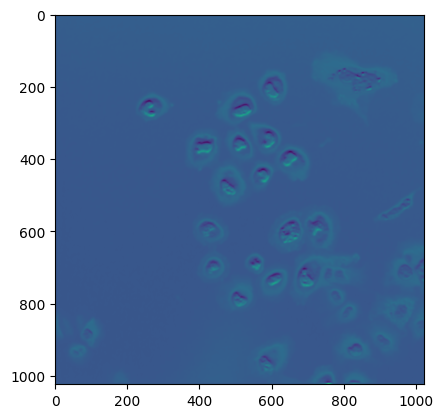

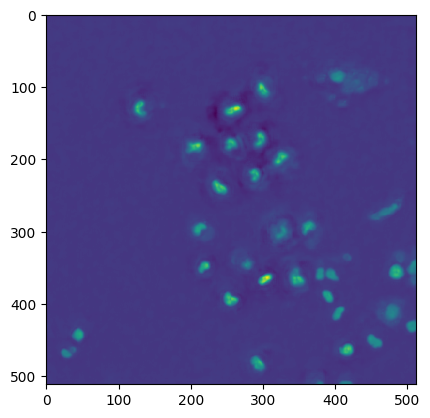

In [132]:
#make a prediction and let's apply modifications

def make_pred(unet, image):
    image = image.unsqueeze(0).unsqueeze(0)
    image = image.to('cuda:0')
    y_16_pred, y_32_pred, y_3_pred = unet(image)
    y_32_pred = y_32_pred.squeeze(0)
    y_3_pred = y_3_pred.squeeze(0)
    y_3_pred = y_3_pred.cpu().detach().numpy()[0]
    return y_3_pred

image = test_images[0]
y_3_pred = make_pred(unet, image)

plt.imshow(y_3_pred)
plt.show()
plt.imshow(test_cellprob[0])
plt.show()

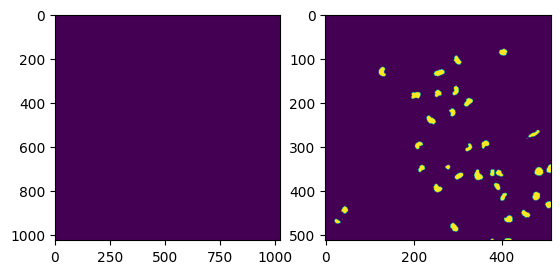

In [133]:
pred = y_3_pred
pred = pred > 0.5

gt = test_cellprob[0]
gt = gt > 0.5

plt.subplot(1,2,1)
plt.imshow(pred)
plt.subplot(1,2,2)
plt.imshow(gt)
plt.show()

In [241]:
#let's calculate the class difference

#get the groundtruth mask
gt_mask = test_cellprob[0]
gt_mask = gt_mask > 0.5

#get the groundtruth cellprob
gt_cp = test_cellprob[0]
gt_cp = F.sigmoid(gt_cp)

#get all the gt_cp values that are 1
gt_cp_0 = gt_cp[gt_mask == 0]
gt_cp_1 = gt_cp[gt_mask == 1]

#get the mean value of gt_cp_0
gt_cp_0_mean = gt_cp_0.mean()
gt_cp_1_mean = gt_cp_1.mean()

pred = y_3_pred
pred = np.resize(pred, (512,512))
#sigmoid the pred
pred = F.sigmoid(torch.from_numpy(pred))
pred_0 = pred[gt_mask == 0]
pred_1 = pred[gt_mask == 1]
pred_0_mean = pred_0.mean()
pred_1_mean = pred_1.mean()

#absolute difference between the contrasts
print(abs(gt_cp_0_mean - gt_cp_1_mean) - abs(pred_0_mean - pred_1_mean))

tensor(0.0031, dtype=torch.float64)
tensor(0.9575, dtype=torch.float64)
tensor(-0.9543, dtype=torch.float64)
tensor(0.4707)
tensor(0.4707)
tensor(-4.6015e-05)
tensor(0.9543, dtype=torch.float64)


c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [150]:
print(gt.unsqueeze(0).shape)
mask0 = gt[:, 0].unsqueeze(1)
mask1 = gt[:, 1].unsqueeze(1)

torch.Size([1, 512, 512])


In [155]:
print(np.unique(mask0))
print(np.unique(mask1))


[False]
[False]


In [ ]:
print(test_cellprob[0])

tensor([[-8.2197, -8.0311, -7.9962,  ..., -7.6628, -7.7984, -7.9332],
        [-8.1718, -8.4967, -8.1357,  ..., -7.6183, -7.8410, -8.0483],
        [-8.1877, -8.8362, -8.4895,  ..., -7.8520, -8.0727, -8.2621],
        ...,
        [-8.1536, -8.7004, -7.9286,  ..., -8.0617, -8.0611, -8.4182],
        [-8.1920, -8.6453, -7.8699,  ..., -7.9053, -8.0869, -8.2721],
        [-7.9803, -8.5260, -8.5515,  ..., -8.3653, -8.5924, -8.5442]],
       dtype=torch.float64)
